# Earthquakes

In [1]:
from requests import get
from datetime import datetime
from json import loads
import pandas as pd

url = url = "https://earthquake.usgs.gov/fdsnws/event/1/query.geojson?minsig=600"

resp = get(url, params={"starttime": datetime(1900, 1, 1), "endtime": datetime(2021, 1, 1)})
json = resp.json()

data = pd.DataFrame.from_dict((i["properties"] for i in json["features"]), orient="columns")
data.set_index("time", inplace=True)

data.index = pd.to_datetime(data.index, unit="ms")
data = data.where(data["mag"] >= 7.0)

<AxesSubplot:xlabel='time'>

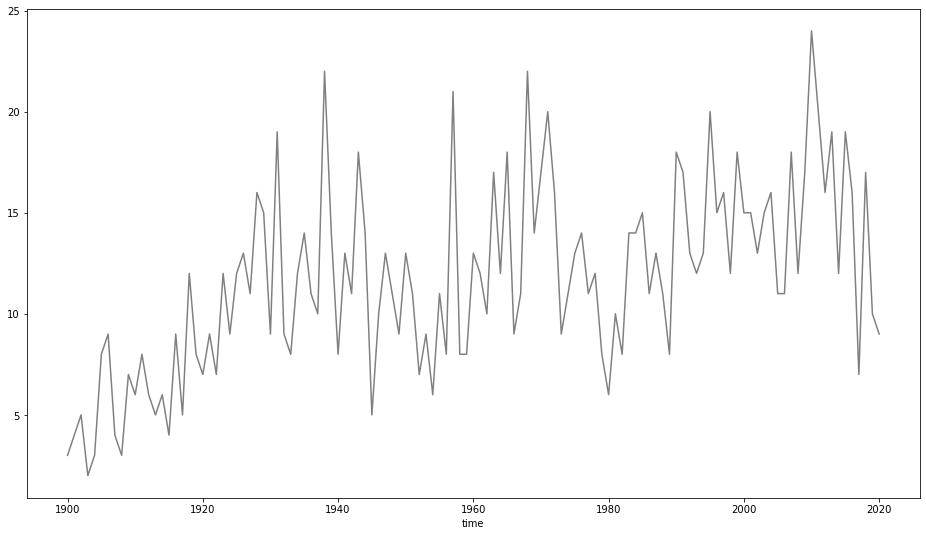

In [2]:
by_year = data.groupby(data.index.year)["mag"].count()

by_year.plot(figsize=(16, 9), color="gray")

In [3]:
from pyfilter.timeseries import models as m, GeneralObservable, StateSpaceModel
from pyfilter.distributions import Prior
from torch.distributions import Poisson, Normal, Exponential, LogNormal
import torch


class EarthquakeObservable(GeneralObservable):
    def build_density(self, x):
        beta = self.functional_parameters()[0]

        return Poisson(rate=beta * x.values.exp(), validate_args=False)
    
priors = Prior(Exponential, rate=5.0), Prior(Normal, loc=0.0, scale=1.0), Prior(LogNormal, loc=0.0, scale=1.0)
latent = m.OrnsteinUhlenbeck(*priors, dt=1.0, ndim=1)

beta = Prior(Exponential, rate=1.0)
obs = EarthquakeObservable(torch.Size([]), (beta,))

ssm = StateSpaceModel(latent, obs)

In [4]:
from pyfilter.inference.batch.mcmc import PMMH, proposals as p
from pyfilter.inference.sequential import SMC2
from pyfilter.filters.particle import APF

as_tensor = torch.from_numpy(by_year.values).int()

filt = APF(ssm, 500)
alg = SMC2(filt, 3000, n_steps=5, threshold=0.9).cuda()

state = alg.fit(as_tensor.cuda())

SMC2: 100%|██████████████████████████████████████████████████████████████████████████| 121/121 [00:27<00:00,  4.36it/s]


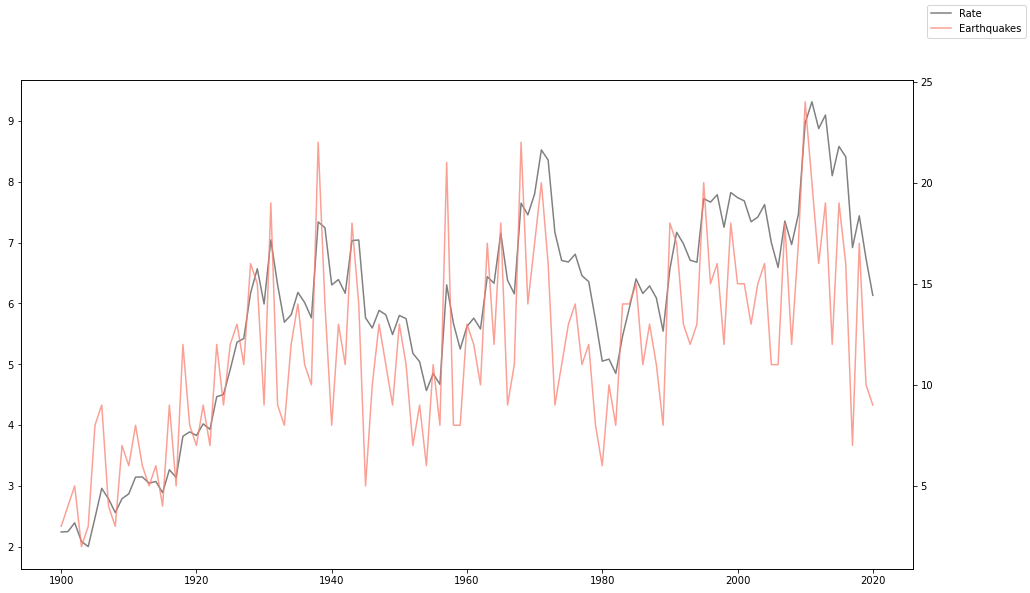

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 9))

ax.plot(by_year.index, state.filter_state.filter_means.mean(1).exp().cpu()[1:], color="gray", label="Rate")

ax2 = ax.twinx()
by_year.plot(ax=ax2, color="salmon", alpha=0.75, label="Earthquakes")

fig.legend()

array([<AxesSubplot:title={'center':'x\n0'}>,
       <AxesSubplot:title={'center':'x\n1'}>,
       <AxesSubplot:title={'center':'x\n2'}>,
       <AxesSubplot:title={'center':'x\n3'}>], dtype=object)

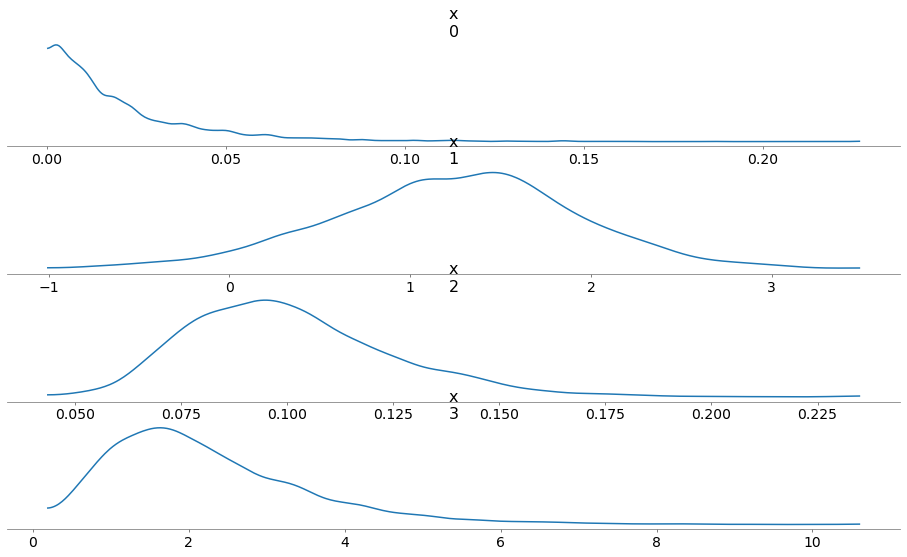

In [8]:
from pyfilter.inference.utils import params_to_tensor
from arviz import plot_posterior

parameters = params_to_tensor(ssm, constrained=True).unsqueeze(0).cpu().numpy()

fig, ax = plt.subplots(parameters.shape[-1], figsize=(16, 9))

plot_posterior(parameters, hdi_prob="hide", point_estimate=None, ax=ax)